In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [7]:
@dataclass
class MOSFET:
    # threshold voltage in Volts
    VTO = 0.7

    # epsilon silicon in F/m
    EPS_Si = 1.04e-10

    # Boltzmann constant in J/K
    K = 1.38e-23

    # charge of an electron in Coulombs
    q = 1.6e-19

    # intrinsic carrier concentration in m^-3
    Ni = 1.5e10

    # substrate doping concentration in m^-3
    NSUB = 1e16

    # permittivity of oxide in F/m
    EPS_OX = 3.45e-11

    # oxide thickness in m
    tox = 1.0e-7

    # oxide capacitance in F/m^2
    cox = EPS_OX / tox

    # body effect coefficient for threshold in sqrt(V^-1)
    GAMMA = np.sqrt(2 * q * EPS_Si * NSUB) / cox

    # mobility in m^2/V/s
    UO = 1.0e-4

    # process transconductance parameter in A/V^2 for long-channel devices
    KP = UO * cox

    # channel length modulation parameter in V^-1 for short-channel devices
    lambda_ = 0.01

    # channel width and length in m
    L = 1e-6
    W = 1e-6

    # Lateral diffusion in m
    LD = 1e-7

    # Accounts for masking and etching effects
    XL = 1e-7

    # Lateral diffusion into channel from bulk along width
    WD = 1e-7

    # Accounts for masking and etching effects
    XW = 1e-7

    # effective channel width and length in m
    Weff = L + XL - 2 * LD
    Leff = W + XW - 2 * WD

    def thermal_voltage(self, temperature):
        """Thermal voltage in Volts."""
        return self.K * temperature / self.q

    def PHI(self, temperature):
        """Surface potential in Volts."""
        return 2 * self.thermal_voltage(temperature) * np.log(self.NSUB / self.Ni)

    def Vth(self, Vsb, temperature):
        """threshold voltage in Volts."""
        phi = self.PHI(temperature)
        return self.VTO + self.GAMMA * (np.sqrt(phi + Vsb) - np.sqrt(phi))

    def Ids(self, Vgs, Vds, Vsb, temperature):
        """Drain source current in Amperes."""
        vth = self.Vth(Vsb, temperature)
        if Vgs < vth:
            return 0
        elif Vds < (Vgs - vth):
            return (
                self.KP
                * (self.Weff / self.Leff)
                * (1 + self.lambda_ * Vds)
                * (Vgs - vth - Vds / 2)
                * Vds
            )
        else:
            return (
                0.5
                * self.KP
                * (self.Weff / self.Leff)
                * (1 + self.lambda_ * Vds)
                * ((Vgs - vth) ** 2)
            )


Vth: 0.700 V


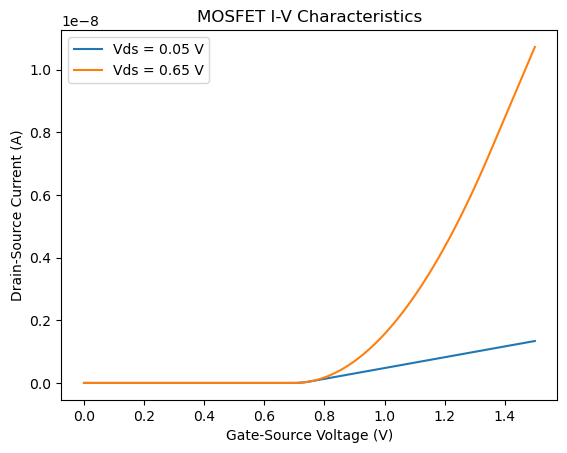

In [12]:
vgs = np.linspace(0, 1.5, 100)
temperature = 300
vbs = 0.0
mosfet = MOSFET()

print(f"Vth: {mosfet.Vth(vbs, temperature):.3f} V")

fig, ax = plt.subplots()

vds = 0.05
ids = np.zeros_like(vgs)
for i, vgs_val in enumerate(vgs):
    ids[i] = mosfet.Ids(vgs_val, vds, vbs, temperature)

ax.plot(vgs, ids, label=f"Vds = {vds} V")

vds = 0.65
ids = np.zeros_like(vgs)
for i, vgs_val in enumerate(vgs):
    ids[i] = mosfet.Ids(vgs_val, vds, vbs, temperature)
ax.plot(vgs, ids, label=f"Vds = {vds} V")


ax.set_xlabel("Gate-Source Voltage (V)")
ax.set_ylabel("Drain-Source Current (A)")
ax.set_title("MOSFET I-V Characteristics")

# ax.set_yscale("log")

ax.legend()